# Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import dill as pkl
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from eval_funcs import (
        perplexity_for_corpora,
        wasserstein_distance_embeddings,
        classify_real_vs_synth,
        compute_stat_properties,
        compute_opt_embeddings
    )

from coherence_utils import compute_topic_coherence

[nltk_data] Downloading package stopwords to /home/archy2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/archy2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Real Dataset

In [2]:
cnn_train = pd.read_csv('../Data_Eval/train.csv')

In [3]:
cnn_train.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


# Import Phi Synthetic Dataset

In [4]:
phi_data = pd.read_csv('../Phi3_Generations/phi3_articles_felipe.csv') # .drop('Unnamed: 0', axis=1)

In [5]:
phi_data.head()

,uniqueID,topic,article
0,05656102-fcdd-4b70-ad7a-0039406f6757,Business - Media,In a significant event that intertwines busine...
1,775eddb0-9cc9-4db2-a637-8ed28e413148,Tech - Foreseeable Future,In a groundbredependent development for Silico...
2,c95435a5-7b53-413f-8c34-8c6fed200919,Science - Space,A fiery meteor shower lit up New York City's n...
3,fc623cae-7512-4214-85a3-b3b0f5123b36,Science - Weather,A powerful storm system that has been causing ...
4,c5f1e0e5-0e93-4e8b-9904-dee5e00d99d0,Style - Architecture,In a groundbrein breakthrough for sustainable ...


In [6]:
phi_data['article'].shape

(6000,)

In [7]:
phi_data['article'].str.split(' ').transform(lambda x: len(x)).max()

np.int64(585)

# Run Eval Functions

### Running Statistical Properties Metrics on Phi Data

In [8]:
stats = compute_stat_properties(phi_data['article'], max_length=4096)
with open('pickles/phi_stats.pkl', 'wb') as f:
    pkl.dump(stats, f)

/home/archy2/kira/.dsc261_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
stats

{'avg_len_tokens': 564.1480102539062,
 'std_len_tokens': 96.44075775146484,
 'avg_len_chars': 3133.2361666666666,
 'ttr': 0.010485723604444224,
 'hapax_ratio': 0.15391767390753106}

### Running Perplexity Scores

In [10]:
ppl = perplexity_for_corpora(cnn_train['article'].sample(1000, random_state=42), phi_data['article'].sample(1000, random_state=42), batch_size=8, max_length=2048)
with open('pickles/phi_ppl.pkl', 'wb') as f:
    pkl.dump(ppl, f)

[perplexity] device=cuda batch_size=8 max_length(requested)=2048 max_length(effective)=2048
[perplexity] num_docs: real=1000 synthetic=1000 total_batches=250
[perplexity] progress 5/250 | elapsed=0.7s | avg/batch=0.14s | ETA~34.8s
[perplexity] progress 10/250 | elapsed=1.4s | avg/batch=0.14s | ETA~32.8s
[perplexity] progress 15/250 | elapsed=2.1s | avg/batch=0.14s | ETA~33.2s
[perplexity] progress 20/250 | elapsed=2.7s | avg/batch=0.14s | ETA~31.6s
[perplexity] progress 25/250 | elapsed=3.5s | avg/batch=0.14s | ETA~31.3s
[perplexity] progress 30/250 | elapsed=4.1s | avg/batch=0.14s | ETA~29.8s
[perplexity] progress 35/250 | elapsed=4.7s | avg/batch=0.13s | ETA~29.0s
[perplexity] progress 40/250 | elapsed=5.4s | avg/batch=0.14s | ETA~28.4s
[perplexity] progress 45/250 | elapsed=6.1s | avg/batch=0.13s | ETA~27.6s
[perplexity] progress 50/250 | elapsed=6.8s | avg/batch=0.14s | ETA~27.4s
[perplexity] progress 55/250 | elapsed=7.6s | avg/batch=0.14s | ETA~27.0s
[perplexity] progress 60/250 

In [11]:
ppl

{'real': {'corpus_ppl': 20.093419261016994},
 'synthetic': {'corpus_ppl': 28.508940807353664}}

### Running Wasserstein Distance

In [12]:
wd = wasserstein_distance_embeddings(cnn_train['article'].sample(1000, random_state=42), phi_data['article'].sample(1000, random_state=42), n_projections=128, batch_size=32)
with open('pickles/phi_wd.pkl', 'wb') as f:
        pkl.dump(wd, f)

[embed:real] device=cuda batch_size=32 max_length(req)=2048 max_length(eff)=2048 num_docs=1000
[embed:real] progress 5/32 | elapsed=2.8s | avg/batch=0.56s | ETA~15.0s
[embed:real] progress 10/32 | elapsed=5.5s | avg/batch=0.55s | ETA~12.0s
[embed:real] progress 15/32 | elapsed=8.3s | avg/batch=0.55s | ETA~9.4s
[embed:real] progress 20/32 | elapsed=10.9s | avg/batch=0.54s | ETA~6.5s
[embed:real] progress 25/32 | elapsed=13.7s | avg/batch=0.55s | ETA~3.8s
[embed:real] progress 30/32 | elapsed=16.4s | avg/batch=0.55s | ETA~1.1s
[embed:real] progress 32/32 | elapsed=17.1s | avg/batch=0.53s | ETA~0.0s
[embed:real] done in 17.1s
[embed:synthetic] device=cuda batch_size=32 max_length(req)=2048 max_length(eff)=2048 num_docs=1000
[embed:synthetic] progress 5/32 | elapsed=0.7s | avg/batch=0.14s | ETA~3.8s
[embed:synthetic] progress 10/32 | elapsed=1.4s | avg/batch=0.14s | ETA~3.1s
[embed:synthetic] progress 15/32 | elapsed=2.1s | avg/batch=0.14s | ETA~2.4s
[embed:synthetic] progress 20/32 | elap

In [13]:
wd

{'mean_distance': 0.18156281552149267,
 'distances': [0.06493823095466554,
  0.2490761032881671,
  0.1385524187703483,
  0.12226694057903874,
  0.06989098387690662,
  0.07351698687074115,
  0.053340434714731697,
  0.09801910583411136,
  0.23233584530268628,
  0.04048423340126521,
  0.2872891752630955,
  0.4842233309736857,
  0.05417032728167798,
  0.25225285885467813,
  0.23159480422579215,
  0.13579480741304478,
  0.12048174351867931,
  0.3778615301809219,
  0.03091667751458501,
  0.22101235515829068,
  0.06582675668344976,
  0.18646919019375346,
  0.04237333005635502,
  0.03414744172816263,
  0.3041325669761723,
  0.30811169768460145,
  0.07510960590555844,
  0.042435765766187024,
  0.36939135955502783,
  0.23446316424871377,
  0.2016738068786642,
  0.04378850411077816,
  0.14060382461320248,
  0.04411437390776713,
  0.29540540217612465,
  0.0772072603624126,
  0.23523919577853675,
  0.08009990320849122,
  0.12128786209748685,
  0.16648992620926045,
  0.28402954692499854,
  0.1175033

### Runnning Classification (Real vs. Synthetic)

In [14]:
clf_res = classify_real_vs_synth(cnn_train['article'].sample(1000, random_state=42), phi_data['article'].sample(1000, random_state=42), cv=5)
with open('pickles/phi_clf_res.pkl', 'wb') as f:
        pkl.dump(clf_res, f)

[classify] batch_size=8 max_length=2048 cv=5 Cs=[0.1, 0.5, 1.0, 2.0, 5.0]
[embed:real] device=cuda batch_size=8 max_length(req)=2048 max_length(eff)=2048 num_docs=1000
[embed:real] progress 5/125 | elapsed=0.6s | avg/batch=0.11s | ETA~13.2s
[embed:real] progress 10/125 | elapsed=1.1s | avg/batch=0.11s | ETA~12.5s
[embed:real] progress 15/125 | elapsed=1.7s | avg/batch=0.11s | ETA~12.4s
[embed:real] progress 20/125 | elapsed=2.2s | avg/batch=0.11s | ETA~11.5s
[embed:real] progress 25/125 | elapsed=2.8s | avg/batch=0.11s | ETA~11.1s
[embed:real] progress 30/125 | elapsed=3.3s | avg/batch=0.11s | ETA~10.3s
[embed:real] progress 35/125 | elapsed=3.8s | avg/batch=0.11s | ETA~9.8s
[embed:real] progress 40/125 | elapsed=4.3s | avg/batch=0.11s | ETA~9.2s
[embed:real] progress 45/125 | elapsed=4.8s | avg/batch=0.11s | ETA~8.6s
[embed:real] progress 50/125 | elapsed=5.5s | avg/batch=0.11s | ETA~8.2s
[embed:real] progress 55/125 | elapsed=6.1s | avg/batch=0.11s | ETA~7.8s
[embed:real] progress 60

In [15]:
clf_res

{'metrics': {'accuracy': 1.0, 'macro_f1': 1.0, 'roc_auc': 1.0},
 'report': {'real': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 200.0},
  'synthetic': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 200.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 400.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 400.0}},
 'embeddings_shape': (2000, 768),
 'classifier': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregressioncv',
                  LogisticRegressionCV(Cs=[0.1, 0.5, 1.0, 2.0, 5.0], cv=5,
                                       max_iter=5000, n_jobs=-1,
                                       scoring='roc_auc', solver='saga'))])}

### Running Coherence Metrics

In [16]:
coherence_result = compute_topic_coherence(
        phi_data['article'],
        sample_size=1000,
        num_topics=15,
        random_seed=42
    )
with open('pickles/phi_coherence_result.pkl', 'wb') as f:
    pkl.dump(coherence_result, f)

Processing texts: 100%|██████████| 1000/1000 [00:00<00:00, 1039.67it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment var

In [17]:
coherence_result

{'coherence_score': np.float64(0.46406253994275615),
 'model_info': {'num_topics': 15, 'dictionary_size': 6637, 'num_docs': 1000},
 'data_info': {'input_texts': 6000, 'processed_texts': 1000, 'sampled': True},
 'parameters': {'sample_size': 1000,
  'no_below': 5,
  'no_above': 0.5,
  'num_passes': 5,
  'random_seed': 42},
 'timestamp': '2025-12-08 12:18:00'}

# Data Quality Visualizations

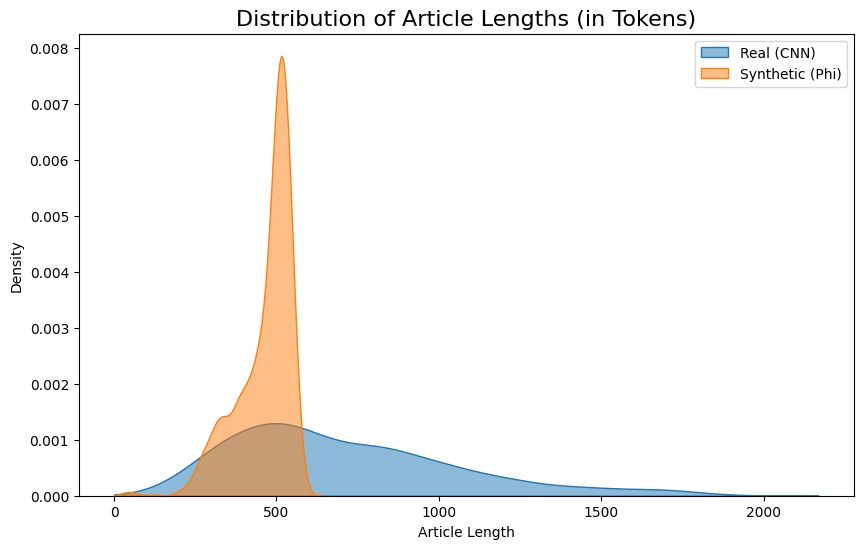

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample real data to match synthetic data size
real_texts = cnn_train['article'].sample(1000, random_state=42)
synth_texts = phi_data['article'].sample(1000, random_state=42)

len_real = real_texts.str.split().str.len()
len_synth = synth_texts.str.split().str.len()

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(len_real, label='Real (CNN)', fill=True, alpha=0.5, clip=(0, 4000))
sns.kdeplot(len_synth, label='Synthetic (Phi)', fill=True, alpha=0.5, clip=(0, 4000))

plt.title('Distribution of Article Lengths (in Tokens)', fontsize=16)
plt.xlabel('Article Length')
plt.ylabel('Density')
plt.legend()
folder_path = "./figures/phi"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path + '/article_length_distribution.png')
plt.show()

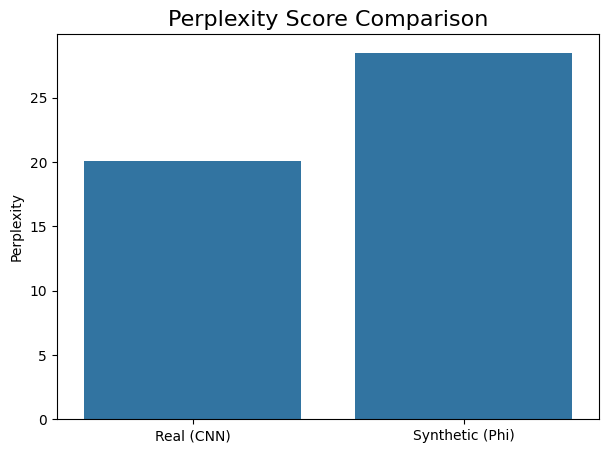

In [22]:
# 1. Get the data from your 'ppl' variable
ppl_scores = {
    'Real (CNN)': ppl['real']['corpus_ppl'],
    'Synthetic (Phi)': ppl['synthetic']['corpus_ppl']
}

# 2. Create the plot
plt.figure(figsize=(7, 5))
sns.barplot(x=list(ppl_scores.keys()), y=list(ppl_scores.values()))

plt.title('Perplexity Score Comparison', fontsize=16)
plt.ylabel('Perplexity')
folder_path = "./figures/phi"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path+'/perplexity_comparison.png')
plt.show()

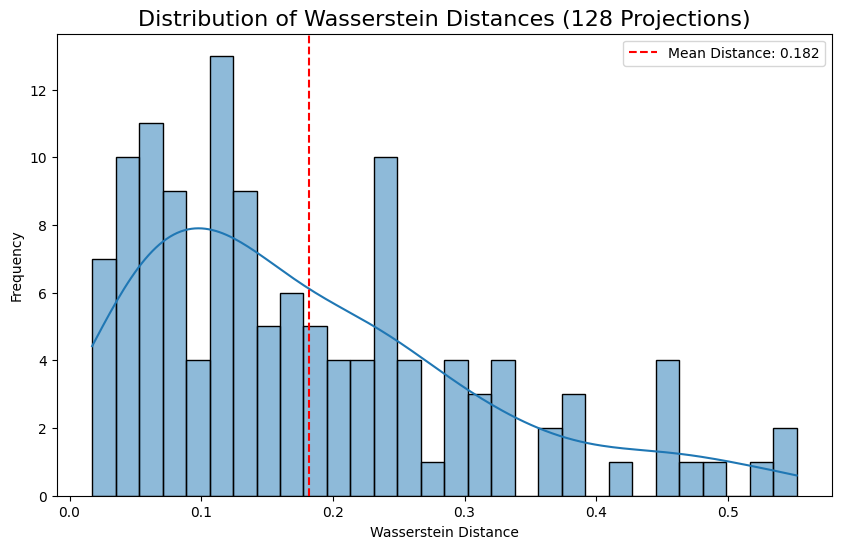

In [23]:
# Get data from 'wd'
distances = wd['distances']
mean_dist = wd['mean_distance']

# Create plot
plt.figure(figsize=(10, 6))
sns.histplot(distances, bins=30, kde=True)

plt.axvline(mean_dist, color='red', linestyle='--', label=f'Mean Distance: {mean_dist:.3f}')
plt.title('Distribution of Wasserstein Distances (128 Projections)', fontsize=16)
plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.legend()
folder_path = "./figures/phi"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path+'/wasserstein_distance_distribution.png')
plt.show()

Computing embeddings for REAL texts (for t-SNE)...
[embed:real_tsne] device=cuda batch_size=8 max_length(req)=2048 max_length(eff)=2048 num_docs=1000
[embed:real_tsne] progress 5/125 | elapsed=0.5s | avg/batch=0.11s | ETA~13.0s
[embed:real_tsne] progress 10/125 | elapsed=1.1s | avg/batch=0.11s | ETA~12.4s
[embed:real_tsne] progress 15/125 | elapsed=1.7s | avg/batch=0.11s | ETA~12.4s
[embed:real_tsne] progress 20/125 | elapsed=2.2s | avg/batch=0.11s | ETA~11.5s
[embed:real_tsne] progress 25/125 | elapsed=2.8s | avg/batch=0.11s | ETA~11.1s
[embed:real_tsne] progress 30/125 | elapsed=3.3s | avg/batch=0.11s | ETA~10.3s
[embed:real_tsne] progress 35/125 | elapsed=3.8s | avg/batch=0.11s | ETA~9.7s
[embed:real_tsne] progress 40/125 | elapsed=4.3s | avg/batch=0.11s | ETA~9.2s
[embed:real_tsne] progress 45/125 | elapsed=4.8s | avg/batch=0.11s | ETA~8.6s
[embed:real_tsne] progress 50/125 | elapsed=5.5s | avg/batch=0.11s | ETA~8.2s
[embed:real_tsne] progress 55/125 | elapsed=6.1s | avg/batch=0.11

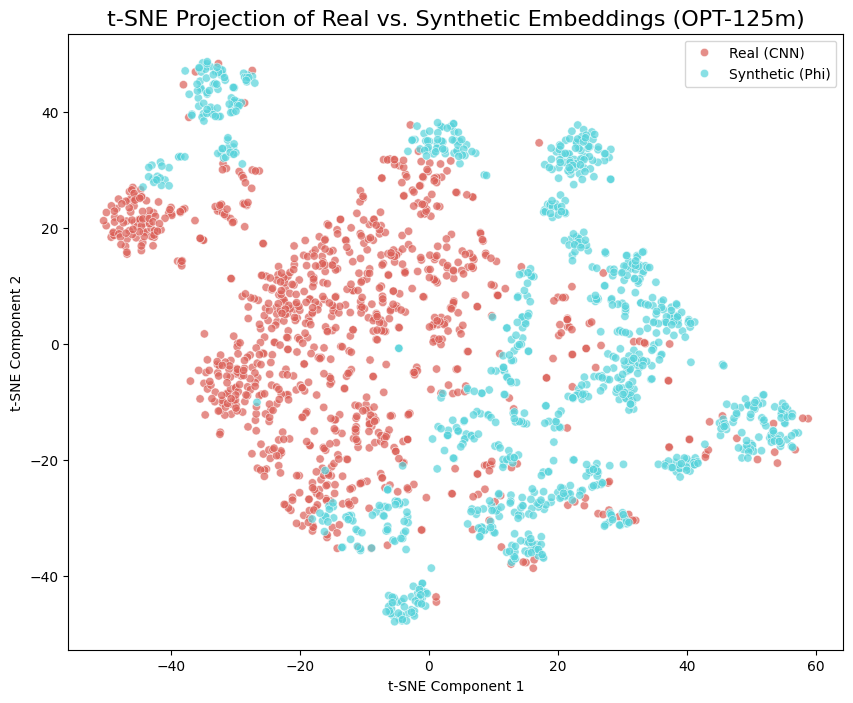

In [25]:
from sklearn.manifold import TSNE

# Compute embeddings
real_texts = cnn_train['article'].sample(1000, random_state=42)
synth_texts = phi_data['article'].sample(1000, random_state=42)

print("Computing embeddings for REAL texts (for t-SNE)...")
Er = compute_opt_embeddings(
    real_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="real_tsne"
)

print("\nComputing embeddings for SYNTHETIC texts (for t-SNE)...")
Es = compute_opt_embeddings(
    synth_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="synth_tsne"
)

# Combine embeddings and create labels
embeddings = np.concatenate([Er, Es], axis=0)
labels = ['Real (CNN)'] * len(Er) + ['Synthetic (Phi)'] * len(Es)

print(f"\nRunning t-SNE on {embeddings.shape[0]} embeddings")

# Reduce 768 dimensions down to 2
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(embeddings)

# Create dataframe and plot

df_tsne = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'label': labels
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=df_tsne,
    alpha=0.7
)

plt.title('t-SNE Projection of Real vs. Synthetic Embeddings (OPT-125m)', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')
folder_path = "./figures/phi"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path+'/tsne_embeddings.png')
plt.show()